<hr style="border:2px solid gray">

#**NOTE:**  Run all cells until Step 1

### Import libraries and define the data path

In [2]:
# import the necessary libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [3]:
%%capture

!pip install category_encoders==2.*
from category_encoders import OrdinalEncoder

In [4]:
#Update the DATA_PATH variable

import sys

if 'google.colab' in sys.modules:
  # If you're on Colab:
  DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/ds_code_along_unit_2/main/data/flight/'
else:
  # If you're working locally:
  DATA_PATH = '..../data/'

### Wrangle the dataset

We are going to work on the Flight dataset today. Instead of predicting the price, we will convert the problem into a binary classification task, and try to predict if the flight is operated by a particular airline of interest or not.

The wrangle function below is very similar to the previous code-along notebook, with a few differences. We will no longer keep the ```Date_of_Journey``` column as we will be using use cross-validation in today's notebook, and want to avoid working with time-series cross-validation. This topic will be covered in Unit 4. Furthermore, we will be working with only the train csv file and not the test file.

In [11]:
def wrangle(filepath):
  df = pd.read_excel(filepath)

  # Drop row(s) where there is/are missing values
  df.dropna(inplace = True)

  # Duration is in a string format. Converting duration into minutes.
  df['Duration'] = df['Duration'].apply(convert_duration)

  # formatting the stops. 'non-stop' output is replaced by 0 in the Total_Stops,
  # and the rest of the values would be filled in by the number of stops

  df['Total_Stops'] = df['Total_Stops'].str.split(" ").str[0] # grabs just the digit or non-stop
  df.replace({'Total_Stops': 'non-stop'}, 0 , inplace = True)

  # Converting the stops dtype to int
  df['Total_Stops'] = df["Total_Stops"].astype(int)

  # drop the columns that are not needed
  df.drop(columns=['Date_of_Journey', 'Route','Dep_Time','Arrival_Time','Additional_Info'], inplace=True)

  # ADD: create new binary target column
  df['Jet_Airways'] = np.where((df['Airline'] == 'Jet Airways Business') | (df['Airline'] == 'Jet Airways'), 1, 0)

  # ADD: drop airline column to prevent data leakage
  df.drop(columns='Airline', inplace=True)


  return df

def convert_duration(duration): # converts to minutes
    if len(duration.split()) == 2:
        hours = int(duration.split()[0][:-1]) # strip off the "h"
        minutes = int(duration.split()[1][:-1]) # strip off the "m"
        return hours * 60 + minutes
    else:
        return int(duration[:-1]) * 60 # just hours and no minutes


df = wrangle(DATA_PATH + 'Data_Train.xlsx')

In [12]:
# cleaned datasets after wrangling
df.head()

,Source,Destination,Duration,Total_Stops,Price,Jet_Airways
0,Banglore,New Delhi,170,0,3897,0
1,Kolkata,Banglore,445,2,7662,0
2,Delhi,Cochin,1140,2,13882,1
3,Kolkata,Banglore,325,1,6218,0
4,Banglore,New Delhi,285,1,13302,0


In [13]:
# do we have any null values?
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Source       10682 non-null  object
 1   Destination  10682 non-null  object
 2   Duration     10682 non-null  int64 
 3   Total_Stops  10682 non-null  int64 
 4   Price        10682 non-null  int64 
 5   Jet_Airways  10682 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 584.2+ KB


<hr style="border:2px solid gray">

#**STEP: 1/4** - Convert multi-class target into binary target

In [ ]:
# we will modify our multi-class problem to a binary problem
# we will predict whether or not the flight is being operated by Jet Airways

df['Airline'].value_counts()

In [ ]:
  # ADD following lines to the Wrangle function

  # # create new binary target column
  # df['Jet_Airways'] = np.where((df['Airline'] == 'Jet Airways Business') | (df['Airline'] == 'Jet Airways'), 1, 0)

  # # drop airline column to prevent data leakage
  # df.drop(columns='Airline', inplace=True)

In [15]:
df.head()

,Source,Destination,Duration,Total_Stops,Price,Jet_Airways
0,Banglore,New Delhi,170,0,3897,0
1,Kolkata,Banglore,445,2,7662,0
2,Delhi,Cochin,1140,2,13882,1
3,Kolkata,Banglore,325,1,6218,0
4,Banglore,New Delhi,285,1,13302,0


In [16]:
# Split the data into Feature Matrix and Target Vector

target = 'Jet_Airways'
y = df[target]
X = df.drop(columns=target)

<hr style="border:2px solid gray">

#**STEP: 2/4** - Randomized Search method

In [17]:
# Build model pipeline

clf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

# Build dictionary with parameters names (str) as keys and distributions or lists of parameters to try.

param_dist = {
  'randomforestclassifier__max_depth': range(5, 20, 5),
  'randomforestclassifier__n_estimators': range(25, 100, 25)
}


In [18]:
# RandomizedSearchCV Method

model_rf_random = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=5, # how many combinations to try
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_rf_random.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 20, 5),
                                        'randomforestclassifier__n_estimators': range(25, 100, 25)},
                   verbose=1)

In [19]:
# Parameter setting that gave the best results on the hold out data.
model_rf_random.best_params_

{'randomforestclassifier__n_estimators': 75,
 'randomforestclassifier__max_depth': 15}

In [20]:
# Mean cross-validated score of the best_estimator
model_rf_random.best_score_

np.float64(0.9634905508264413)

<hr style="border:2px solid gray">

#**STEP: 3/4** - Re-train a new model and build confusion matrix

In [21]:
# Randomly split data into Train and Validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Determine the baseline for our classification task
print('BASELINE accuracy', y_train.value_counts(normalize=True).max())

BASELINE accuracy 0.6423639555295494


In [23]:
# Build a new Random Forest model with the Search Method results

model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        max_depth=15,
        n_estimators=75
    )
)

model_rf.fit(X_train,y_train);


In [24]:
# Evaluate the model performance and compare it to the baseline

print('RF training accuracy:', accuracy_score(y_train, model_rf.predict(X_train)))
print('RF validation accuracy:', accuracy_score(y_val, model_rf.predict(X_val)))

RF training accuracy: 0.9957870099473376
RF validation accuracy: 0.9620963968179691


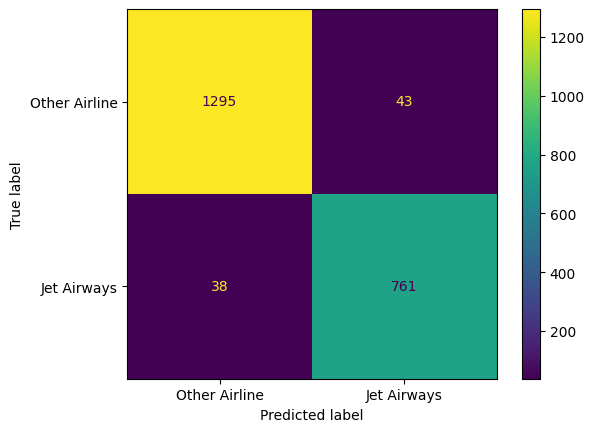

In [26]:
# Build confusion matrix

ConfusionMatrixDisplay.from_estimator(
  model_rf,
  X_val,
  y_val,
  values_format='.0f',
  display_labels=['Other Airline', 'Jet Airways']
);

In [ ]:
# precision = tp /(tp+fp)
# recall = tp /(tp+fn)
# accuracy = (tn+tp)/(tn+fp+fn+tp)
# f1-score = 2 * (precision * recall) / (precision + recall)

<hr style="border:2px solid gray">

#**STEP: 4/4** - Modify classification threshold

In [27]:
# Build classification report

print(classification_report(y_val,
                            model_rf.predict(X_val),
                            target_names=['Other Airline', 'Jet Airways']))

               precision    recall  f1-score   support

Other Airline       0.97      0.97      0.97      1338
  Jet Airways       0.95      0.95      0.95       799

     accuracy                           0.96      2137
    macro avg       0.96      0.96      0.96      2137
 weighted avg       0.96      0.96      0.96      2137



In [28]:
# Determine model predictions
y_pred = model_rf.predict(X_val)

# Select a new threshold value
classification_threshold = 0.45

# Determine the prediction probabilities
y_pred_proba = model_rf.predict_proba(X_val)[:, -1]


In [29]:
y_pred = model_rf.predict(X_val)
y_pred_new = y_pred.copy()

In [30]:
# Apply the new threshold to get new predictions

y_pred_new[y_pred_proba >= classification_threshold] = 1
y_pred_new[y_pred_proba < classification_threshold] = 0

In [31]:
# Check accuracy metric with new classification threshold
print('RF validation accuracy -- new threshold:', accuracy_score(y_val, y_pred_new))

RF validation accuracy -- new threshold: 0.9611605053813758


In [32]:
# Build classification report with new predictions

print(classification_report(y_val,
                            y_pred_new,
                            target_names=['Other Airline', 'Jet Airways']))

               precision    recall  f1-score   support

Other Airline       0.98      0.96      0.97      1338
  Jet Airways       0.94      0.96      0.95       799

     accuracy                           0.96      2137
    macro avg       0.96      0.96      0.96      2137
 weighted avg       0.96      0.96      0.96      2137

